In [1]:
import sys
sys.path.append("..") #this is to add the avobe folder to the package directory
import geopandas as gpd
import pandas as pd
import nexus_tool.weap_tools as wp
import matplotlib.pyplot as plt
import shapely
import os

## Reading files

In [2]:
gis_folder = os.path.join('Data', 'GIS')
sch_folder = os.path.join('Data', 'Schematic')

governorates = gpd.read_file(os.path.join(gis_folder, 'Admin', 'JOR_adm1.shp'))
links = gpd.read_file(os.path.join(sch_folder, 'Transmission Links.kml'))
groundwater = gpd.read_file(os.path.join(sch_folder, 'Groundwater.kml'))
river_withdrawals = gpd.read_file(os.path.join(sch_folder, 'River Withdrawals.kml'))
wwtp = gpd.read_file(os.path.join(sch_folder, 'Wastewater Treatment Plants.kml'))
other_supply = gpd.read_file(os.path.join(sch_folder, 'Other Supplies.kml'))
demand_sites = gpd.read_file(os.path.join(sch_folder, 'Demand Sites.kml'))
tributary_inflows = gpd.read_file(os.path.join(sch_folder, 'Tributary Inflows.kml'))
diversion_outflows = gpd.read_file(os.path.join(sch_folder, 'Diversion Outflows.kml'))
diversion = gpd.read_file(os.path.join(sch_folder, 'Diversions.kml'))

## Converting geometries and dropping unecesary columns

In [3]:
for gdf in [links, groundwater, river_withdrawals, wwtp, other_supply, 
            demand_sites, tributary_inflows, diversion, diversion_outflows]:
    gdf['geometry'] = wp.polyz_to_poly(gdf)
    gdf.drop(columns='Description', inplace=True)

## Defining supply, demand points and transmissions

In [4]:
for gdf in [groundwater, river_withdrawals, wwtp, other_supply, 
            diversion_outflows, demand_sites, tributary_inflows]:
    gdf.rename(columns={'Name': 'point'}, inplace=True)

links.rename(columns={'Name': 'links'}, inplace=True)
diversion.rename(columns={'Name': 'diversion'}, inplace=True)

## Reprojecting layers

In [5]:
PalestineBelt = 28192
for gdf in [links, groundwater, governorates, river_withdrawals, wwtp, 
            other_supply, demand_sites, tributary_inflows, diversion, 
            diversion_outflows]:
    gdf.crs = 4326
    gdf.to_crs(epsg=PalestineBelt, inplace=True)

## Defining types

In [6]:
groundwater['type'] = 'Groundwater supply'
river_withdrawals['type'] = 'River/pipeline supply'
wwtp['type'] = 'Wastewater plant'
other_supply['type'] = 'Other supply'
other_supply.loc[other_supply.point=='RedDead', 'type'] = 'Desalination'
other_supply.loc[other_supply.point=='Aqaba Desal', 'type'] = 'Desalination'
other_supply = other_supply.loc[other_supply['type']!='Other supply']
demand_sites['type'] = 'Municipality'
demand_sites.loc[demand_sites['point'].str.contains('Agri'), 'type'] = 'Agriculture'
demand_sites.loc[demand_sites['point'].str.contains('Ind'), 'type'] = 'Industry'
tributary_inflows['type'] = 'Tributary inflow'
diversion['type'] = 'Transmission Pipeline'
diversion_outflows['type'] = 'Diversion Outflow'

## Joining water transmition network points

In [7]:
points = tributary_inflows.append([diversion_outflows, river_withdrawals],
                                  ignore_index=True, sort=False)

## Calculate length of distribution and transmission links

In [8]:
links['length_m'] = links.length
diversion['pl_length_m'] = diversion.length

## Sampling raster data

In [9]:
groundwater['wtd_m'] = wp.sample_raster(os.path.join(gis_folder, 
                                                     'Water Table Depth', 
                                                     'Jordan_wtd_projected.tif'), 
                                        groundwater)

supply = groundwater.append([river_withdrawals, wwtp, other_supply], 
                            ignore_index=True, sort=False)
supply = gpd.sjoin(supply, links, how='inner', op='intersects')
supply.drop(columns='index_right', inplace=True)
demand = gpd.sjoin(demand_sites, links, how='inner', op='intersects')
demand.drop(columns='index_right', inplace=True)

points['elevation_m'] = wp.sample_raster(os.path.join(gis_folder, 
                                                      'DEM', 
                                                      'DEM_projected.tif'), 
                                         points)
demand['elevation_m'] = wp.sample_raster(os.path.join(gis_folder, 
                                                      'DEM', 
                                                      'DEM_projected.tif'), 
                                         demand)
supply['elevation_m'] = wp.sample_raster(os.path.join(gis_folder, 
                                                      'DEM', 
                                                      'DEM_projected.tif'), 
                                         supply)

## Intersect distribution links with supply and demand

In [10]:
distribution = gpd.sjoin(links, supply, how='inner', op='intersects')
distribution.drop(columns='index_right', inplace=True)
distribution = gpd.sjoin(distribution, demand, how='inner', op='intersects')
distribution.drop(columns='index_right', inplace=True)
distribution['type'] = 'Distribution link'

## Plotting the system

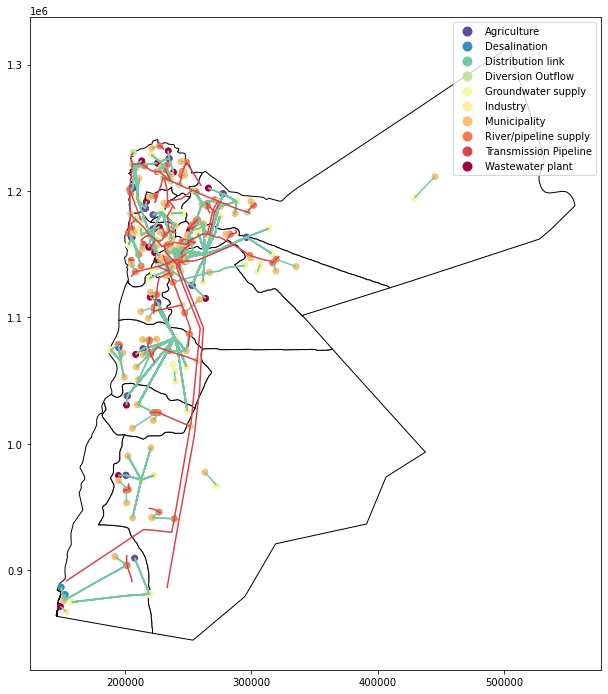

In [11]:
base = governorates.plot(color='white', edgecolor='black', figsize=(12, 12))
data = distribution.append([supply, demand, diversion, diversion_outflows], ignore_index=True, sort=False)
data.plot(ax=base, column='type', cmap='Spectral_r', legend=True)
plt.show()

## Split segment in the pipeline system

In [12]:
points_coords = points.geometry.unary_union
list_gdf = []
i = 0

for pipeline in diversion.iterrows():
    split_pipeline = shapely.ops.split(pipeline[1].geometry, points_coords)
    segments = [feature for feature in split_pipeline]
    index = list(range(i, len(segments) + i))
    gdf_segments = gpd.GeoDataFrame(index, geometry=segments)
    gdf_segments.columns = ['index', 'geometry']
    gdf_segments['pipeline'] = pipeline[1].diversion
    gdf_segments['pl_length_m'] = pipeline[1].pl_length_m
    gdf_segments.crs = f'epsg:{PalestineBelt}'
    intersections = gpd.sjoin(gdf_segments, points, how='inner', op='intersects')
    list_gdf.append(intersections)
    i = list_gdf[-1]['index'].max() + 1
    
pipelines = gpd.GeoDataFrame(pd.concat(list_gdf, ignore_index=True))
pipelines.crs = supply.crs

## Calculate each segment lenght

In [13]:
pipelines = gpd.GeoDataFrame(pd.concat(list_gdf, ignore_index=True))
pipelines['segment_length_m'] = pipelines.length

## Plot the pipeline segments

<AxesSubplot:>

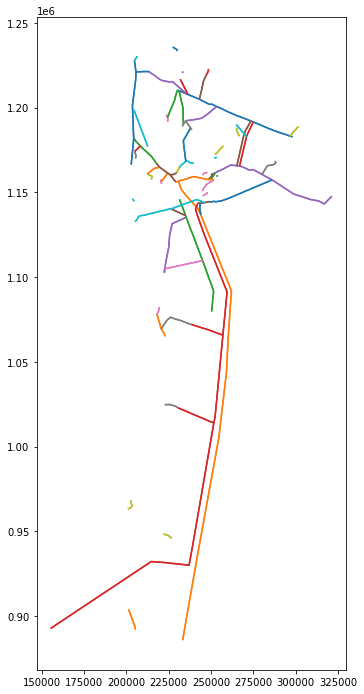

In [14]:
x = []

for name in pipelines.pipeline.unique():
    _df = pipelines.loc[pipelines.pipeline==name].copy()
    for index in _df['index'].unique():
        _df2 = _df.loc[pipelines['index']==index]
        if _df2.shape[0] == 1:
            x.append(_df2.index.values[0])
            
pipelines.loc[~pipelines.index.isin(x)].plot(figsize=(12,12), column='pipeline', categorical=True)

## Standardizing names

In [15]:
demand['point'] = demand['point'].str.replace('Agriculture', 'Agri')

## Save the spatial layers

In [16]:
folder = os.path.join(gis_folder, 'Processed layers') #Define the output folder path
os.makedirs(folder, exist_ok=True)
demand.to_file(os.path.join(folder, 'Demand_points.gpkg'), driver='GPKG')
supply.to_file(os.path.join(folder, 'Supply_points.gpkg'), driver='GPKG')
pipelines.to_file(os.path.join(folder, 'Pipelines.gpkg'), driver='GPKG')

## Save coordinates for visualization

In [17]:
all_points_coords = pd.DataFrame(demand.append(supply, sort=False, ignore_index=True).to_crs(epsg=4326))
all_points_coords.drop_duplicates(subset="point", inplace=True)
all_points_coords['lon'] = [point.xy[0][0] for point in all_points_coords.geometry]
all_points_coords['lat'] = [point.xy[1][0] for point in all_points_coords.geometry]
all_points_coords.drop(columns=['geometry', 'links', 'length_m', 'elevation_m', 'wtd_m'], inplace=True)

pipe_coords = pd.DataFrame({'lon': [], 'lat': []})
for name, point in zip(pipelines.pipeline, pipelines.to_crs(epsg=4326).geometry):
    lon = list(point.xy[0]) + [None]
    lat = list(point.xy[1]) + [None]
    df_temp = pd.DataFrame({'lon': lon, 'lat': lat})
    df_temp['name'] = name
    pipe_coords = pipe_coords.append(df_temp, ignore_index=True)
pipe_coords['type'] = 'pipeline'

In [19]:
folder = os.path.join('..', 'Jordan dashboard', 'spatial_data')
all_points_coords.to_csv(os.path.join(folder, 'points_coords.csv'), index=False)
pipe_coords.to_csv(os.path.join(folder, 'pipe_coords.csv'), index=False)